# ArtifactGEN Exploration
Visualize real vs synthetic EEG windows; update paths as needed.

TUAR root: C:\works\TUAR
Figures will be saved to: paper\figs
edf subdirs:
 - 01_tcp_ar
 - 02_tcp_le
 - 03_tcp_ar_a
Found 310 EDF segments


Processing sample records: 100%|██████████| 50/50 [00:00<00:00, 1100.09it/s]

Sample summary (first 50 files):
 - Unique labels: 14
 - Top-10 labels: [('eyem', 5504), ('musc', 5330), ('elec', 4058), ('eyem_musc', 3269), ('chew', 1527), ('musc_elec', 1353), ('eyem_elec', 808), ('eyem_chew', 273), ('elpp', 172), ('shiv', 161)]
 - Unique channels: 22
 - Top-10 channels: [('FP1-F3', 1988), ('FP2-F8', 1979), ('FP2-F4', 1970), ('FP1-F7', 1958), ('F4-C4', 1153), ('F3-C3', 1116), ('F8-T4', 989), ('F7-T3', 957), ('T4-A2', 822), ('C4-T4', 801)]
 - Events with durations:  22529
   duration mean=6.48s, median=1.65s, p95=22.25s
 - Montage files (top): [('01_tcp_ar_montage.txt', 50)]
 - Files with seizure CSV: 4 / 50


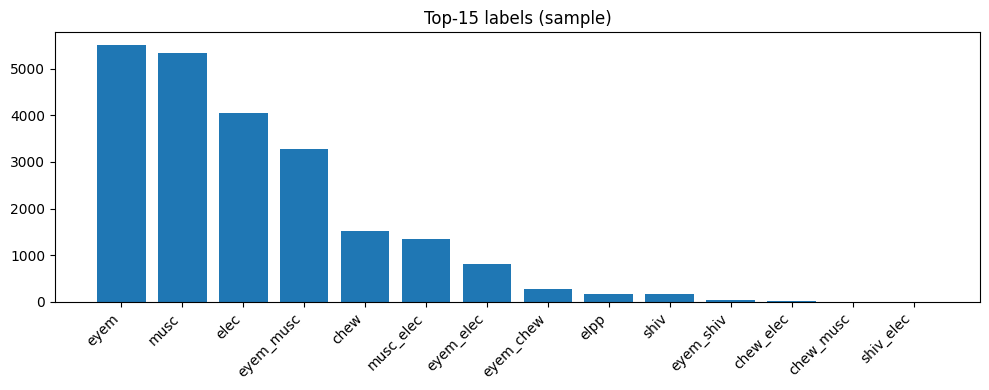

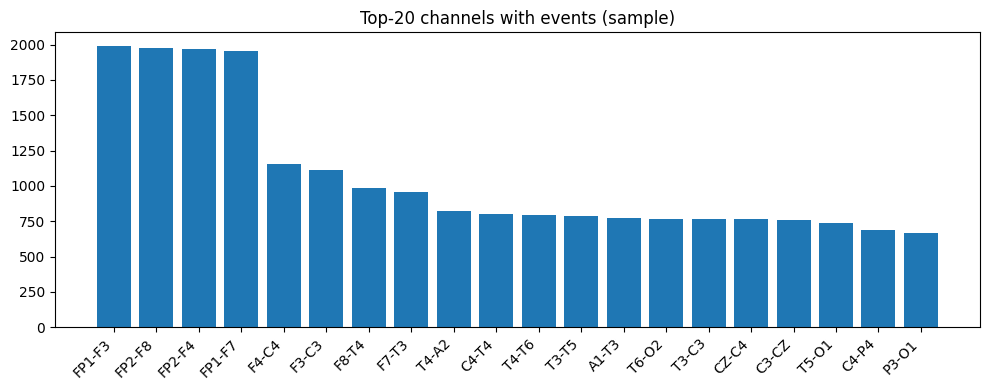

Unique subjects in sample: 32


In [4]:
# TUAR quick exploration utilities
import os, csv, json, re
from pathlib import Path
from collections import Counter, defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm

# Configure your TUAR base directory here
TUAR_ROOT = Path("C:/works/TUAR").resolve()
print("TUAR root:", TUAR_ROOT)

# Setup for saving figures
figs_dir = Path('paper/figs')
figs_dir.mkdir(parents=True, exist_ok=True)
print("Figures will be saved to:", figs_dir)

# 1) List channel configuration subfolders under edf/
edf_dir = TUAR_ROOT / "edf"
subdirs = sorted([p for p in edf_dir.glob("*") if p.is_dir()])
print("edf subdirs:")
for s in subdirs:
    print(" -", s.name)

# 2) Enumerate EDF files and paired CSVs
records = []
for sub in subdirs:
    for edf_path in sub.glob("*.edf"):
        stem = edf_path.stem  # e.g., aaaaaaju_s005_t000
        csv_path = edf_path.with_suffix(".csv")
        seiz_csv = edf_path.with_name(edf_path.stem + "_seiz.csv")
        records.append({
            "subdir": sub.name,
            "edf": edf_path,
            "csv": csv_path if csv_path.exists() else None,
            "seiz": seiz_csv if seiz_csv.exists() else None,
            "subject": stem.split("_")[0],
            "session": stem.split("_")[1] if "_" in stem else None,
            "token": stem.split("_")[-1] if "_" in stem else None,
        })

print(f"Found {len(records)} EDF segments")

# 3) Parse CSV headers for metadata and collect event rows for a sample
header_keys = ["version", "bname", "duration", "montage_file", "annotation_label_file"]


def read_annotation_csv(csv_path: Path):
    meta = {k: None for k in header_keys}
    events = []
    if csv_path is None or not csv_path.exists():
        return meta, events
    with open(csv_path, "r", encoding="utf-8") as f:
        reader = csv.reader(f)
        for row in reader:
            if not row:
                continue
            if row[0].startswith("#"):
                # Header lines: format like '# key = value'
                line = ",".join(row)
                m = re.match(r"#\s*([a-z_]+)\s*=\s*(.*)", line, re.IGNORECASE)
                if m:
                    k, v = m.group(1).strip(), m.group(2).strip()
                    if k in meta:
                        meta[k] = v
                continue
            if row[0].lower() == "channel":
                # column header
                continue
            # Data lines: channel,start_time,stop_time,label,confidence
            try:
                ch, start, stop, label, conf = row[:5]
                events.append({
                    "channel": ch,
                    "start": float(start),
                    "stop": float(stop),
                    "label": label,
                    "confidence": float(conf),
                })
            except Exception:
                continue
    return meta, events

# Sample N files for event statistics
N = min(50, len(records))
sample_records = records[:N]
label_counts = Counter()
channel_counts = Counter()
durations = []
montage_files = Counter()
have_seiz = 0

for r in tqdm.tqdm(sample_records, desc="Processing sample records"):
    meta, events = read_annotation_csv(r["csv"])
    if meta.get("montage_file"):
        montage_files[Path(meta["montage_file"]).name] += 1
    if r["seiz"] is not None:
        have_seiz += 1
    for e in events:
        label_counts[e["label"]] += 1
        channel_counts[e["channel"]] += 1
        durations.append(e["stop"] - e["start"])

print("Sample summary (first", N, "files):")
print(" - Unique labels:", len(label_counts))
print(" - Top-10 labels:", label_counts.most_common(10))
print(" - Unique channels:", len(channel_counts))
print(" - Top-10 channels:", channel_counts.most_common(10))
print(" - Events with durations: ", len(durations))
if durations:
    arr = np.array(durations)
    print(f"   duration mean={arr.mean():.2f}s, median={np.median(arr):.2f}s, p95={np.percentile(arr,95):.2f}s")
print(" - Montage files (top):", montage_files.most_common(5))
print(" - Files with seizure CSV:", have_seiz, "/", N)

# 4) Plot label histogram for the sample
plt.figure(figsize=(10,4))
labels, counts = zip(*label_counts.most_common(15)) if label_counts else ([], [])
plt.bar(labels, counts)
plt.title("Top-15 labels (sample)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(figs_dir / 'top15_labels_sample.png')
plt.show()

# 5) Estimate per-channel event frequency
plt.figure(figsize=(10,4))
chs, ccounts = zip(*channel_counts.most_common(20)) if channel_counts else ([], [])
plt.bar(chs, ccounts)
plt.title("Top-20 channels with events (sample)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(figs_dir / 'top20_channels_sample.png')
plt.show()

# 6) Sketch subject-wise split feasibility (unique subjects in sample)
subjects = {r['subject'] for r in sample_records}
print("Unique subjects in sample:", len(subjects))

In [5]:
# Deep dive into one annotation file
from pprint import pprint

# Pick first record that has annotations
one = next((r for r in records if r['csv'] is not None and r['csv'].exists()), None)
print("Example file:", one)
meta, events = read_annotation_csv(one['csv']) if one else ({}, [])
print("Metadata:")
pprint(meta)

# Per-label duration stats
by_label = defaultdict(list)
for e in events:
    by_label[e['label']].append(e['stop'] - e['start'])

label_stats = {
    k: {
        'n': len(v),
        'mean_s': float(np.mean(v)) if v else 0.0,
        'p50_s': float(np.median(v)) if v else 0.0,
        'p95_s': float(np.percentile(v, 95)) if v else 0.0,
        'max_s': float(np.max(v)) if v else 0.0,
    }
    for k, v in by_label.items()
}
print("Per-label duration stats (example file):")
pprint(label_stats)

# Overlap rate estimation per channel
# Sort events by channel and start time
from itertools import groupby

def overlap_rate(evts):
    if not evts:
        return 0.0
    evts = sorted(evts, key=lambda e: e['start'])
    overlaps = 0
    prev_end = -1.0
    for e in evts:
        if e['start'] < prev_end:
            overlaps += 1
        prev_end = max(prev_end, e['stop'])
    return overlaps / len(evts)

ov_by_channel = {}
for ch, group in groupby(sorted(events, key=lambda e: (e['channel'], e['start'])), key=lambda e: e['channel']):
    evts = list(group)
    ov_by_channel[ch] = overlap_rate(evts)

print("Overlap rate by channel (example file, first 10):")
print(dict(list(ov_by_channel.items())[:10]))

# Recommend window length based on p95 of durations
all_durations = [e['stop'] - e['start'] for e in events]
if all_durations:
    p95 = float(np.percentile(all_durations, 95))
    recommended = 2.0 if p95 > 1.0 else 1.0
    print(f"Recommended window length ≈ {recommended}s (p95={p95:.2f}s)")
else:
    print("No events to analyze for window length.")

Example file: {'subdir': '01_tcp_ar', 'edf': WindowsPath('C:/works/TUAR/edf/01_tcp_ar/aaaaaaju_s005_t000.edf'), 'csv': WindowsPath('C:/works/TUAR/edf/01_tcp_ar/aaaaaaju_s005_t000.csv'), 'seiz': None, 'subject': 'aaaaaaju', 'session': 's005', 'token': 't000'}
Metadata:
{'annotation_label_file': '$TUAR/v3.0.0/DOCS/nedc_ann_eeg_tools_map_v01.txt',
 'bname': 'aaaaaaju_s005_t000',
 'duration': '1442.0000 secs',
 'montage_file': '$TUAR/v3.0.0/DOCS/01_tcp_ar_montage.txt',
 'version': 'csv_v1.0.0'}
Per-label duration stats (example file):
{'eyem': {'max_s': 7.095099999999999,
          'mean_s': 4.481533333333345,
          'n': 24,
          'p50_s': 3.3130000000000166,
          'p95_s': 7.095099999999999}}
Overlap rate by channel (example file, first 10):
{'F3-C3': 0.0, 'F4-C4': 0.0, 'F7-T3': 0.0, 'F8-T4': 0.0, 'FP1-F3': 0.0, 'FP1-F7': 0.0, 'FP2-F4': 0.0, 'FP2-F8': 0.0}
Recommended window length ≈ 2.0s (p95=7.10s)


In [6]:
# Map TUAR short labels to canonical classes for our project
# Use centralized merge_map so notebook visuals match preprocessing
from src.merge_map import remap_label
# label_map maps short keys to nicer display names (post-remap)
# Keep exactly the canonical 5 classes used for training
label_map = {
    'musc': 'Muscle',
    'eyem': 'Eye movement',
    'elec': 'Electrode',
    'chew': 'Chewing',
    'shiv': 'Shiver',
}

remapped = Counter()
# apply remap_label first, then map to display names
for k, v in label_counts.items():
    mk = remap_label(k)
    remapped[label_map.get(mk, mk)] += v

plt.figure(figsize=(8,4))
if remapped:
    labs, cnts = zip(*remapped.most_common())
    plt.bar(labs, cnts)
    plt.xticks(rotation=45, ha='right')
    plt.title('Remapped label distribution (sample)')
    plt.tight_layout()
    plt.savefig(figs_dir / 'remapped_labels_sample.png')
else:
    print('No labels found in sample')
plt.show()

ModuleNotFoundError: No module named 'src'

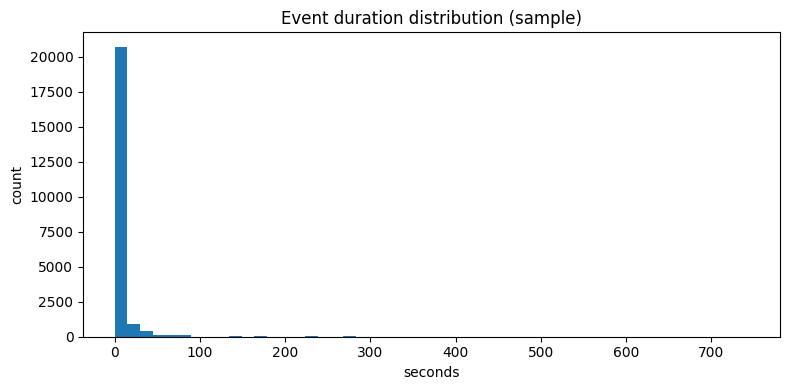

Suggested 8-channel montage subset (present in sample): ['C3-P3', 'C4-P4', 'T3-T5', 'T4-T6']


In [7]:
# Duration distribution and suggested 8-channel set
if durations:
    plt.figure(figsize=(8,4))
    plt.hist(durations, bins=50)
    plt.title('Event duration distribution (sample)')
    plt.xlabel('seconds')
    plt.ylabel('count')
    plt.tight_layout()
    plt.savefig(figs_dir / 'duration_distribution_sample.png')
    plt.show()

# Suggest canonical 8-channel set present in TUAR labels
candidate_channels = ['Fp1-F7','Fp2-F8','C3-P3','C4-P4','O1-O2','T3-T5','T4-T6','Fz-Cz']
available = [ch for ch in candidate_channels if ch in channel_counts]
print('Suggested 8-channel montage subset (present in sample):', available)

c:\works\ArtifactGen\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Building summary vectors: 100%|██████████| 50/50 [00:00<00:00, 1444.87it/s]
c:\works\ArtifactGen\venv\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")

c:\works\ArtifactGen\venv\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


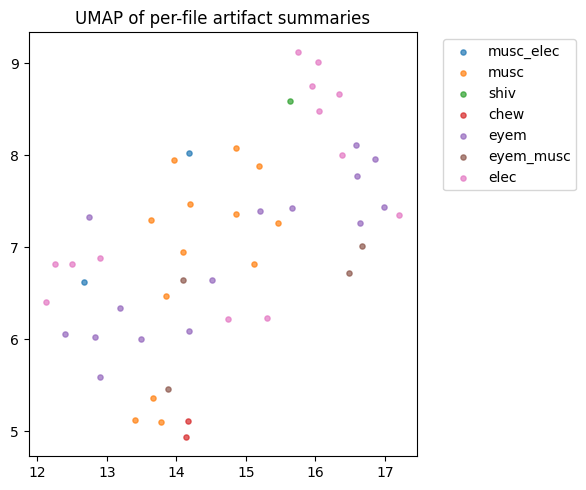

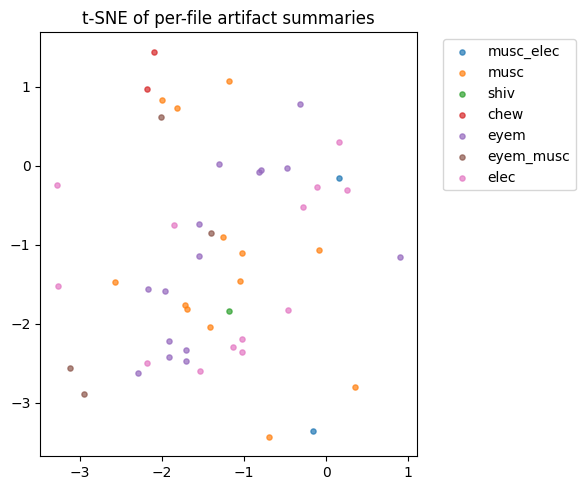

In [8]:
# Feature engineering for visualization (per file sample): label-wise median duration and channel diversity
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import umap

# Build per-file summary vectors
summ_rows = []
for r in tqdm.tqdm(sample_records, desc="Building summary vectors"):
    meta, events = read_annotation_csv(r['csv'])
    if not events:
        continue
    # compute: label counts (subset) and median durations
    lc = Counter([e['label'] for e in events])
    dur_by_label = defaultdict(list)
    ch_by_label = defaultdict(set)
    for e in events:
        dur_by_label[e['label']].append(e['stop'] - e['start'])
        ch_by_label[e['label']].add(e['channel'])
    labels_ref = [k for k,_ in label_counts.most_common(6)]  # top-6 labels in sample
    feat = []
    for lab in labels_ref:
        feat.append(lc.get(lab, 0))
        durs = dur_by_label.get(lab, [])
        feat.append(float(np.median(durs)) if durs else 0.0)
        feat.append(len(ch_by_label.get(lab, set())))
    summ_rows.append({
        'subject': r['subject'],
        'file': str(r['edf'].name),
        'features': np.array(feat, dtype=float),
        'dominant_label': max(lc.items(), key=lambda kv: kv[1])[0] if lc else 'none'
    })

if summ_rows:
    X = np.stack([row['features'] for row in summ_rows])
    y = [row['dominant_label'] for row in summ_rows]
    Xn = StandardScaler().fit_transform(X)

    # UMAP
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
    emb_umap = reducer.fit_transform(Xn)
    plt.figure(figsize=(6,5))
    for lab in set(y):
        idx = [i for i,yy in enumerate(y) if yy==lab]
        plt.scatter(emb_umap[idx,0], emb_umap[idx,1], s=14, label=lab, alpha=0.7)
    plt.title('UMAP of per-file artifact summaries')
    plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
    plt.tight_layout()
    plt.savefig(figs_dir / 'umap_perfile_summaries.png')
    plt.show()

    # t-SNE
    tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=30, random_state=42)
    emb_tsne = tsne.fit_transform(Xn)
    plt.figure(figsize=(6,5))
    for lab in set(y):
        idx = [i for i,yy in enumerate(y) if yy==lab]
        plt.scatter(emb_tsne[idx,0], emb_tsne[idx,1], s=14, label=lab, alpha=0.7)
    plt.title('t-SNE of per-file artifact summaries')
    plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
    plt.tight_layout()
    plt.savefig(figs_dir / 'tsne_perfile_summaries.png')
    plt.show()
else:
    print('No summary rows to embed')

In [9]:
# Subject/session analysis and split suggestion
# Count files per subject and dominant label distribution per subject
subj_files = defaultdict(list)
subj_label_counts = defaultdict(Counter)
for r in tqdm.tqdm(records, desc="Processing all records"):
    meta, events = read_annotation_csv(r['csv'])
    if not events:
        continue
    lc = Counter([e['label'] for e in events])
    dom = max(lc.items(), key=lambda kv: kv[1])[0]
    subj_files[r['subject']].append(r)
    subj_label_counts[r['subject']][dom] += 1

n_subjects = len(subj_files)
print('Subjects with annotations:', n_subjects)

# Heuristic: subject-wise split 70/15/15 stratified by overall dominant label
subjects_sorted = sorted(subj_files.keys(), key=lambda s: sum(subj_label_counts[s].values()), reverse=True)

def stratified_subject_split(subjects, frac=(0.7, 0.15, 0.15)):
    # Bucket subjects by their dominant label
    buckets = defaultdict(list)
    for s in subjects:
        if subj_label_counts[s]:
            dom = max(subj_label_counts[s].items(), key=lambda kv: kv[1])[0]
        else:
            dom = 'none'
        buckets[dom].append(s)
    train, val, test = [], [], []
    for dom, subs in buckets.items():
        k = len(subs)
        t = int(round(frac[0]*k))
        v = int(round(frac[1]*k))
        # ensure all accounted
        tr, va, te = subs[:t], subs[t:t+v], subs[t+v:]
        train += tr
        val += va
        test += te
    return train, val, test

train_subj, val_subj, test_subj = stratified_subject_split(subjects_sorted)
print('Train subjects:', len(train_subj), 'Val subjects:', len(val_subj), 'Test subjects:', len(test_subj))

# Show label distributions per split
split_label_counts = {'train': Counter(), 'val': Counter(), 'test': Counter()}
for split, subs in [('train', train_subj), ('val', val_subj), ('test', test_subj)]:
    for s in subs:
        split_label_counts[split] += subj_label_counts[s]

print('Split label distributions (by dominant label):')
for k, v in split_label_counts.items():
    print(k, dict(v.most_common()))

# Save suggested CSV files in data/processed for downstream use (optional)
import pandas as pd

splits_rows = []
for s in train_subj:
    splits_rows.append({'subject_id': s, 'split': 'train'})
for s in val_subj:
    splits_rows.append({'subject_id': s, 'split': 'val'})
for s in test_subj:
    splits_rows.append({'subject_id': s, 'split': 'test'})

splits_df = pd.DataFrame(splits_rows).drop_duplicates()
splits_out = Path('data/processed/suggested_splits_subjectwise.csv')
splits_out.parent.mkdir(parents=True, exist_ok=True)
splits_df.to_csv(splits_out, index=False)
print('Wrote suggested splits to', splits_out)

Processing all records: 100%|██████████| 310/310 [00:00<00:00, 1754.20it/s]

Subjects with annotations: 213
Train subjects: 149 Val subjects: 32 Test subjects: 32
Split label distributions (by dominant label):
train {'musc': 87, 'eyem': 70, 'elec': 58, 'eyem_musc': 12, 'musc_elec': 9, 'chew': 8, 'shiv': 1, 'chew_musc': 1}
val {'musc': 12, 'eyem': 10, 'elec': 7, 'chew': 1, 'musc_elec': 1, 'eyem_musc': 1}
test {'musc': 13, 'eyem': 9, 'elec': 7, 'eyem_musc': 2, 'musc_elec': 1}
Wrote suggested splits to data\processed\suggested_splits_subjectwise.csv


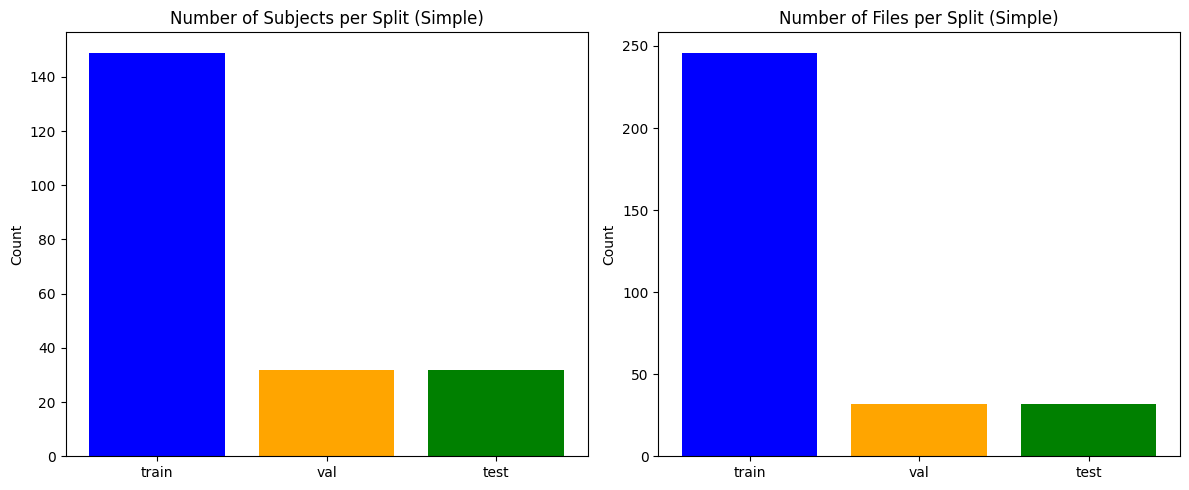

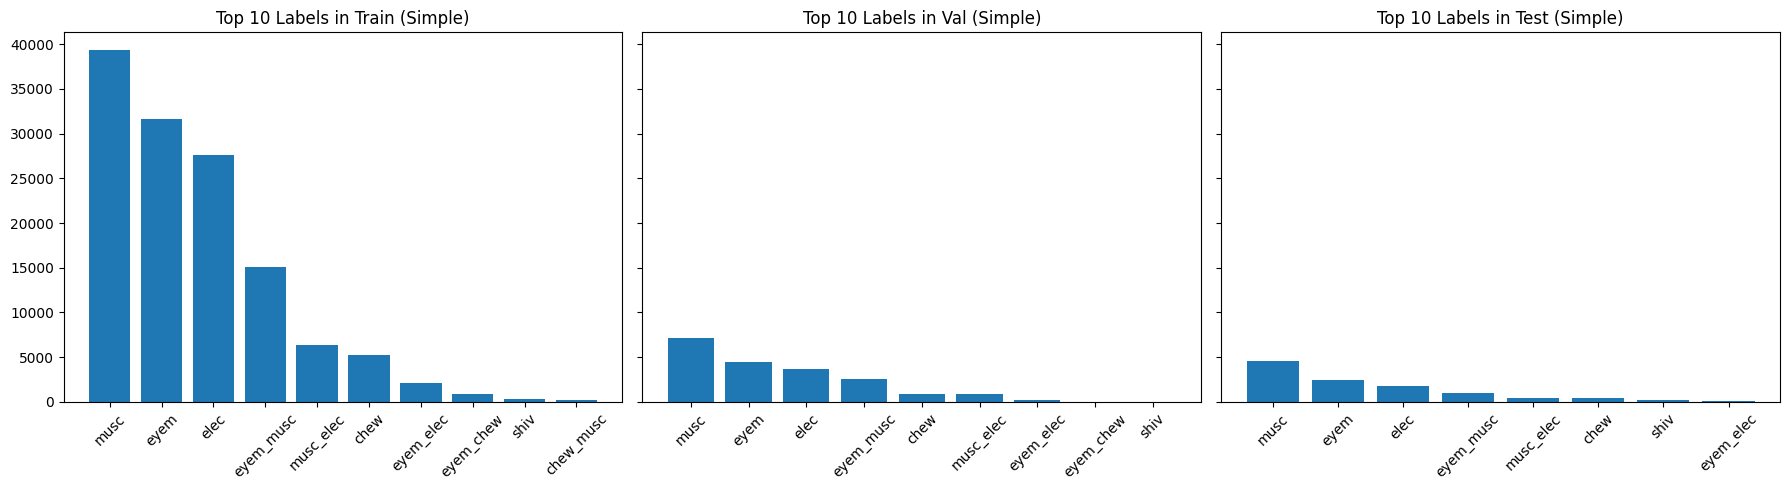

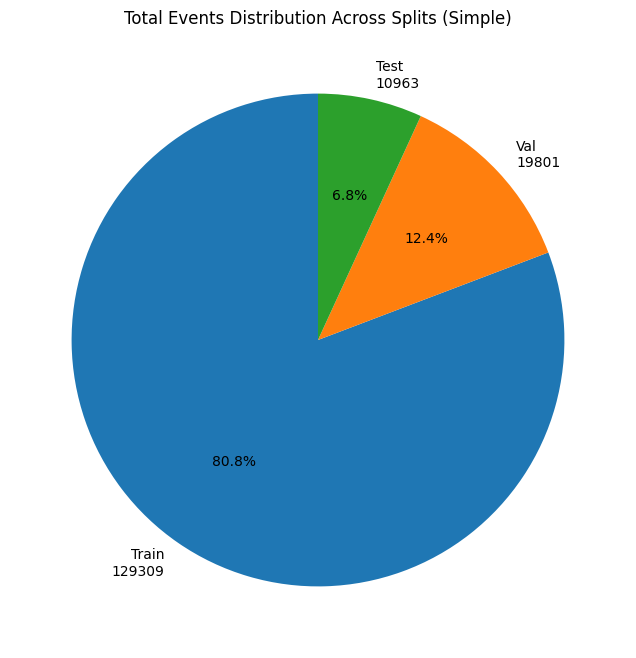

In [10]:
# Visualizations for simple stratified split data spread

# Compute per-split statistics for simple split
split_stats_simple = {'train': {}, 'val': {}, 'test': {}}

for split_name, subj_list in [('train', train_subj), ('val', val_subj), ('test', test_subj)]:
    split_records = [r for r in records if r['subject'] in subj_list]
    label_counts_split = Counter()
    channel_counts_split = Counter()
    durations_split = []
    files_count = len(split_records)
    subjects_count = len(subj_list)
    
    for r in split_records:
        meta, events = read_annotation_csv(r['csv'])
        for e in events:
            label_counts_split[e['label']] += 1
            channel_counts_split[e['channel']] += 1
            durations_split.append(e['stop'] - e['start'])
    
    split_stats_simple[split_name] = {
        'label_counts': label_counts_split,
        'channel_counts': channel_counts_split,
        'durations': durations_split,
        'files': files_count,
        'subjects': subjects_count
    }

# 1) Split sizes: subjects and files
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
splits = ['train', 'val', 'test']
subjects = [split_stats_simple[s]['subjects'] for s in splits]
files = [split_stats_simple[s]['files'] for s in splits]

ax1.bar(splits, subjects, color=['blue', 'orange', 'green'])
ax1.set_title('Number of Subjects per Split (Simple)')
ax1.set_ylabel('Count')

ax2.bar(splits, files, color=['blue', 'orange', 'green'])
ax2.set_title('Number of Files per Split (Simple)')
ax2.set_ylabel('Count')

plt.tight_layout()
plt.savefig(figs_dir / 'split_sizes_simple.png')
plt.show()

# 2) Label distribution per split (top 10)
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
for i, split in enumerate(splits):
    lc = split_stats_simple[split]['label_counts']
    if lc:
        labels, counts = zip(*lc.most_common(10))
        axes[i].bar(labels, counts)
        axes[i].set_title(f'Top 10 Labels in {split.capitalize()} (Simple)')
        axes[i].tick_params(axis='x', rotation=45)
    else:
        axes[i].text(0.5, 0.5, 'No data', ha='center', va='center', transform=axes[i].transAxes)
        axes[i].set_title(f'{split.capitalize()} Labels (Simple)')

plt.tight_layout()
plt.savefig(figs_dir / 'label_dist_per_split_simple.png')
plt.show()

# 3) Pie chart for total events per split
total_events = [sum(split_stats_simple[s]['label_counts'].values()) for s in splits]
fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(total_events, labels=[f'{s.capitalize()}\n{total_events[i]}' for i, s in enumerate(splits)], autopct='%1.1f%%', startangle=90)
ax.set_title('Total Events Distribution Across Splits (Simple)')
plt.savefig(figs_dir / 'events_pie_simple.png')
plt.show()

In [11]:
# Window-length sensitivity by label and overlap summary
# Compute p50/p95 duration per label over the sampled files
label_durations = defaultdict(list)
for r in tqdm.tqdm(sample_records, desc="Computing label durations"):
    meta, events = read_annotation_csv(r['csv'])
    for e in events:
        label_durations[e['label']].append(e['stop'] - e['start'])

wd_table = []
for lab, vals in label_durations.items():
    arr = np.array(vals)
    wd_table.append({
        'label': lab,
        'p50': float(np.percentile(arr, 50)),
        'p95': float(np.percentile(arr, 95)),
        'count': int(len(arr))
    })
wd_df = pd.DataFrame(wd_table).sort_values('p95', ascending=False)
print('Top-10 labels by p95 duration:')
print(wd_df.head(10))

# Overlap ratios (estimated): mean across channels in the example file
if ov_by_channel:
    mean_overlap = float(np.mean(list(ov_by_channel.values())))
    print(f'Mean overlap rate across channels (example): {mean_overlap:.3f}')
else:
    print('No overlap info available from example')

Computing label durations: 100%|██████████| 50/50 [00:00<00:00, 1513.36it/s]

Top-10 labels by p95 duration:
        label       p50       p95  count
12  chew_elec  272.6319  272.6319     22
1   musc_elec    7.0065   49.6799   1353
7   eyem_elec    2.9875   39.8340    808
8   eyem_shiv    4.0191   30.4306     45
2   eyem_musc    1.6985   25.8150   3269
6        chew    2.6167   23.6500   1527
5        elec    0.3912   16.9888   4058
3        musc    2.4000   16.0048   5330
0        eyem    1.3833   12.5199   5504
11  eyem_chew    0.7895   11.3397    273
Mean overlap rate across channels (example): 0.000


# Multi-label, subject-wise stratified split (70/15/15)
We build a subject×label count matrix from TUAR annotations, then assign subjects to train/val/test to match target label proportions and avoid leakage. We:
- Prioritize rare-label subjects first (weighted by 1/label-frequency).
- Greedily place each subject into the split that best reduces the weighted deviation from desired per-split label totals.
- Report per-split coverage and attempt to remedy large deficits in val/test by moving subjects when possible.

Outputs: `data/processed/suggested_splits_subjectwise_multilabel.csv`.

In [14]:
# Build subject × label matrix and perform multi-label stratified split
from collections import defaultdict, Counter
import numpy as np
import pandas as pd
from pathlib import Path

# Collect counts per subject per label (from all records)
subj_label_full = defaultdict(Counter)
all_labels = set()
subj_total = Counter()

for r in tqdm.tqdm(records, desc="Collecting subject-label counts"):
    meta, events = read_annotation_csv(r['csv'])
    if not events:
        continue
    lc = Counter([e['label'] for e in events])
    subj_total[r['subject']] += 1
    for lab, cnt in lc.items():
        subj_label_full[r['subject']][lab] += cnt
        all_labels.add(lab)

subjects_all = sorted(subj_label_full.keys())
labels_all = sorted(all_labels)
print(f"Subjects considered: {len(subjects_all)} | Labels: {len(labels_all)}")

# Build a matrix for convenience
S = len(subjects_all)
L = len(labels_all)
mat = np.zeros((S, L), dtype=float)
for i, s in enumerate(subjects_all):
    for j, lab in enumerate(labels_all):
        mat[i, j] = subj_label_full[s][lab]

label_totals = mat.sum(axis=0)  # total counts per label
print("Nonzero labels:", {labels_all[j]: int(label_totals[j]) for j in range(L) if label_totals[j] > 0})

# Target proportions
frac = (0.70, 0.15, 0.15)
train_target = label_totals * frac[0]
val_target = label_totals * frac[1]
test_target = label_totals * frac[2]

# Weights to prioritize rare labels
with np.errstate(divide='ignore', invalid='ignore'):
    inv_freq = 1.0 / np.maximum(label_totals, 1.0)
    inv_freq /= inv_freq.max() if inv_freq.max() > 0 else 1.0

# Sort subjects by contribution to rare labels: score = sum(counts * inv_freq)
subject_scores = [(i, float((mat[i] * inv_freq).sum())) for i in range(S)]
subject_scores.sort(key=lambda t: t[1], reverse=True)

assign = np.full(S, -1, dtype=int)  # -1 unassigned, 0 train, 1 val, 2 test
current = {
    0: np.zeros(L, dtype=float),
    1: np.zeros(L, dtype=float),
    2: np.zeros(L, dtype=float),
}

# Greedy assignment minimizing weighted deviation from targets
def deviation(after, target):
    # Weighted L1 deviation
    d = np.abs(after - target)
    w = 1.0 + 2.0 * inv_freq  # emphasize rare labels
    return float((d * w).sum())

for i, _score in subject_scores:
    contrib = mat[i]
    # Try each split and pick the best
    best_split, best_obj = None, float('inf')
    candidates = [0, 1, 2]
    # Light subject-count balancing (aim close to frac by subject count)
    n_assigned = (assign != -1).sum()
    n_train = (assign == 0).sum()
    n_val = (assign == 1).sum()
    n_test = (assign == 2).sum()
    subj_target = np.array(frac) * max(n_assigned + 1, 1)
    subj_dev = {
        0: abs((n_train + 1) - subj_target[0]),
        1: abs((n_val + 1) - subj_target[1]),
        2: abs((n_test + 1) - subj_target[2]),
    }
    # Evaluate objective = label deviation + small subject-balance penalty
    for sidx in candidates:
        if sidx == 0:
            obj = deviation(current[0] + contrib, train_target) + \
                  deviation(current[1], val_target) + \
                  deviation(current[2], test_target) + 0.05 * subj_dev[0]
        elif sidx == 1:
            obj = deviation(current[0], train_target) + \
                  deviation(current[1] + contrib, val_target) + \
                  deviation(current[2], test_target) + 0.05 * subj_dev[1]
        else:
            obj = deviation(current[0], train_target) + \
                  deviation(current[1], val_target) + \
                  deviation(current[2] + contrib, test_target) + 0.05 * subj_dev[2]
        if obj < best_obj:
            best_obj, best_split = obj, sidx
    assign[i] = best_split
    current[best_split] += contrib

train_idx = [subjects_all[i] for i in range(S) if assign[i] == 0]
val_idx = [subjects_all[i] for i in range(S) if assign[i] == 1]
test_idx = [subjects_all[i] for i in range(S) if assign[i] == 2]
print("Initial subject counts:", len(train_idx), len(val_idx), len(test_idx))

# Coverage checks: ensure labels appear in each split when feasible
MIN_VAL = 30   # minimum total label-counts in val when possible
MIN_TEST = 5  # minimum total label-counts in test when possible

def label_counts_for(split_subjects):
    if not split_subjects:
        return np.zeros(L)
    idxs = [subjects_all.index(s) for s in split_subjects]
    return mat[idxs].sum(axis=0)

val_counts = label_counts_for(val_idx)
test_counts = label_counts_for(test_idx)

def try_fix_coverage(missing_mask, from_split, to_split):
    # Move the best subject from from_split to to_split to improve missing labels
    improved = False
    src = val_idx if from_split == 'val' else test_idx if from_split == 'test' else train_idx
    dst = val_idx if to_split == 'val' else test_idx if to_split == 'test' else train_idx
    if not src:
        return False
    best_gain, best_s = 0.0, None
    for s in src:
        i = subjects_all.index(s)
        gain = float((mat[i] * missing_mask).sum())
        if gain > best_gain:
            best_gain = gain
            best_s = s
    if best_s is None or best_gain <= 0:
        return False
    # Move
    src.remove(best_s)
    dst.append(best_s)
    return True

# Identify labels under-covered in val/test
val_missing = (val_counts < np.minimum(MIN_VAL, label_totals)).astype(float)
test_missing = (test_counts < np.minimum(MIN_TEST, label_totals)).astype(float)

# Attempt limited fixes by moving from train to val/test
for _ in range(5):
    changed = False
    if val_missing.any():
        if try_fix_coverage(val_missing, 'train', 'val'):
            changed = True
            val_counts = label_counts_for(val_idx)
            val_missing = (val_counts < np.minimum(MIN_VAL, label_totals)).astype(float)
    if test_missing.any():
        if try_fix_coverage(test_missing, 'train', 'test'):
            changed = True
            test_counts = label_counts_for(test_idx)
            test_missing = (test_counts < np.minimum(MIN_TEST, label_totals)).astype(float)
    if not changed:
        break

print("Per-split label totals (top 10 labels):")
for name, subs in [('train', train_idx), ('val', val_idx), ('test', test_idx)]:
    counts = label_counts_for(subs)
    pairs = [(labels_all[j], int(counts[j])) for j in range(L)]
    pairs.sort(key=lambda x: x[1], reverse=True)
    print(name, dict(pairs[:10]))

# Save CSV
rows = []
for s in train_idx:
    rows.append({'subject_id': s, 'split': 'train'})
for s in val_idx:
    rows.append({'subject_id': s, 'split': 'val'})
for s in test_idx:
    rows.append({'subject_id': s, 'split': 'test'})

out_path = Path('data/processed/suggested_splits_subjectwise_multilabel.csv')
out_path.parent.mkdir(parents=True, exist_ok=True)
pd.DataFrame(rows).drop_duplicates().to_csv(out_path, index=False)
print('Wrote multi-label stratified splits to', out_path)

Subjects considered: 213 | Labels: 14
Nonzero labels: {'chew': 6482, 'chew_elec': 152, 'chew_musc': 243, 'elec': 33130, 'elpp': 172, 'eyem': 38569, 'eyem_chew': 864, 'eyem_elec': 2422, 'eyem_musc': 18677, 'eyem_shiv': 45, 'musc': 51052, 'musc_elec': 7651, 'shiv': 613, 'shiv_elec': 1}
Initial subject counts: 139 32 42
Per-split label totals (top 10 labels):
train {'musc': 34066, 'eyem': 24926, 'elec': 22804, 'eyem_musc': 11870, 'musc_elec': 5334, 'chew': 2555, 'eyem_elec': 1458, 'shiv': 261, 'eyem_chew': 190, 'elpp': 44}
val {'musc': 9696, 'eyem': 6482, 'elec': 4608, 'eyem_musc': 3602, 'chew': 2031, 'musc_elec': 981, 'eyem_elec': 416, 'eyem_chew': 362, 'chew_musc': 212, 'shiv': 180}
test {'musc': 7290, 'eyem': 7161, 'elec': 5718, 'eyem_musc': 3205, 'chew': 1896, 'musc_elec': 1336, 'eyem_elec': 548, 'eyem_chew': 312, 'shiv': 172, 'eyem_shiv': 45}
Wrote multi-label stratified splits to data\processed\suggested_splits_subjectwise_multilabel.csv


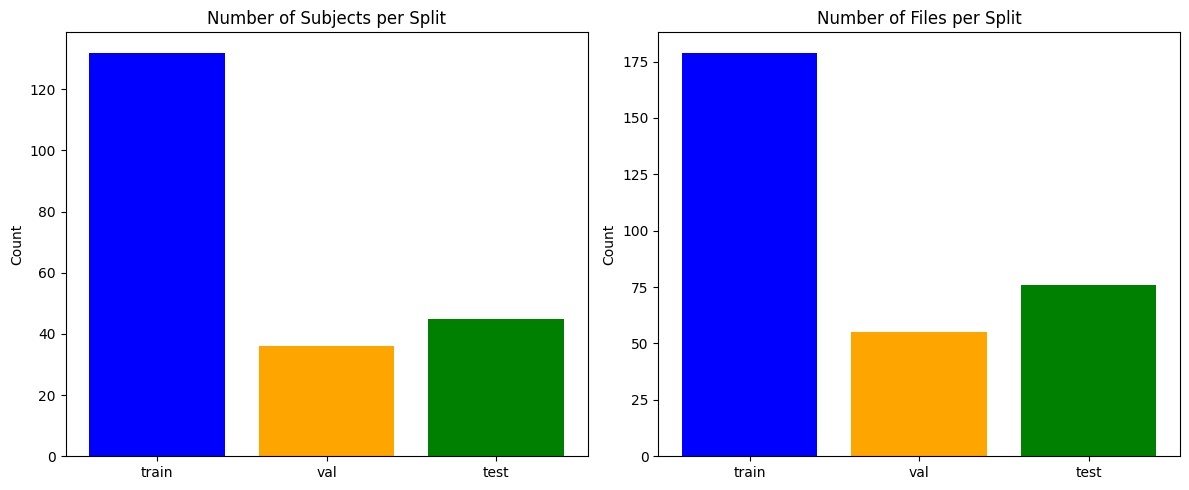

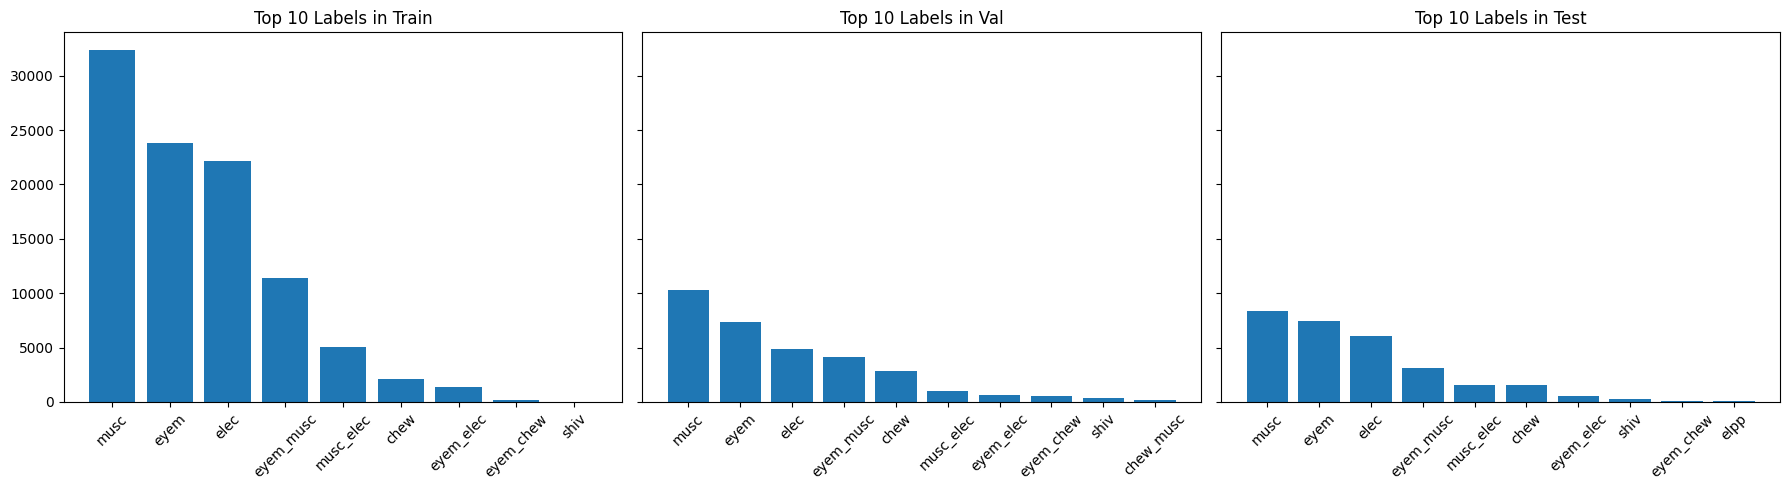

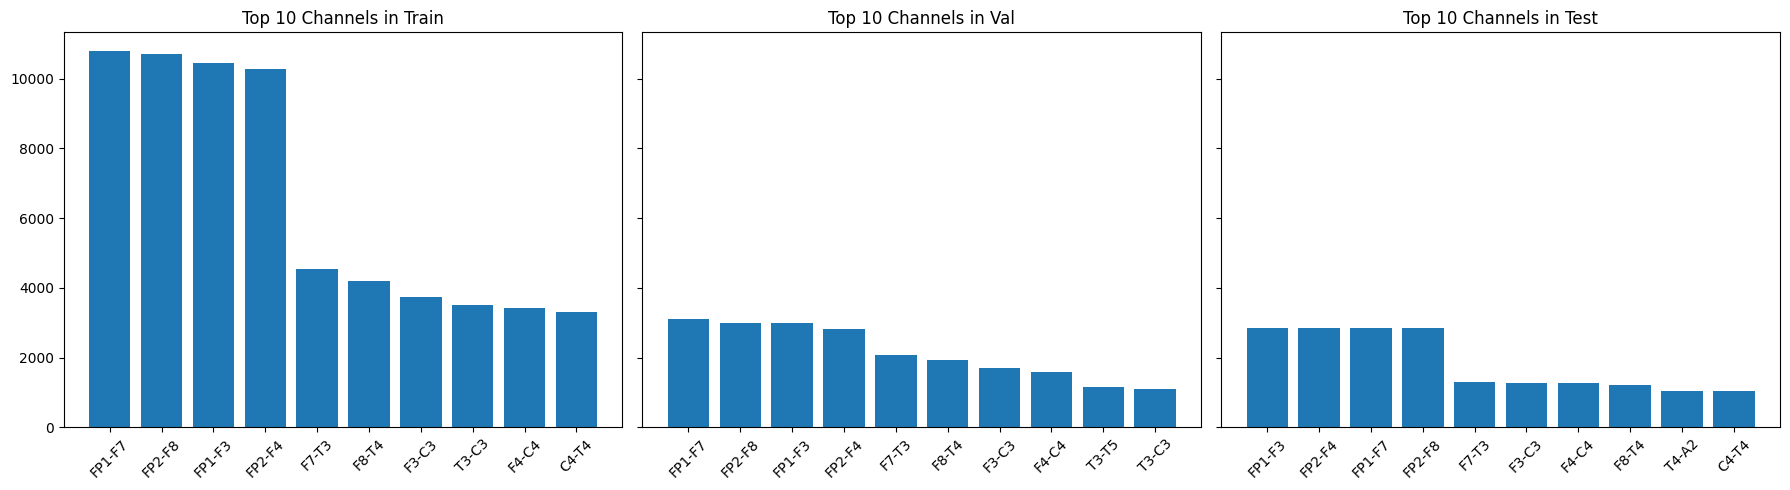

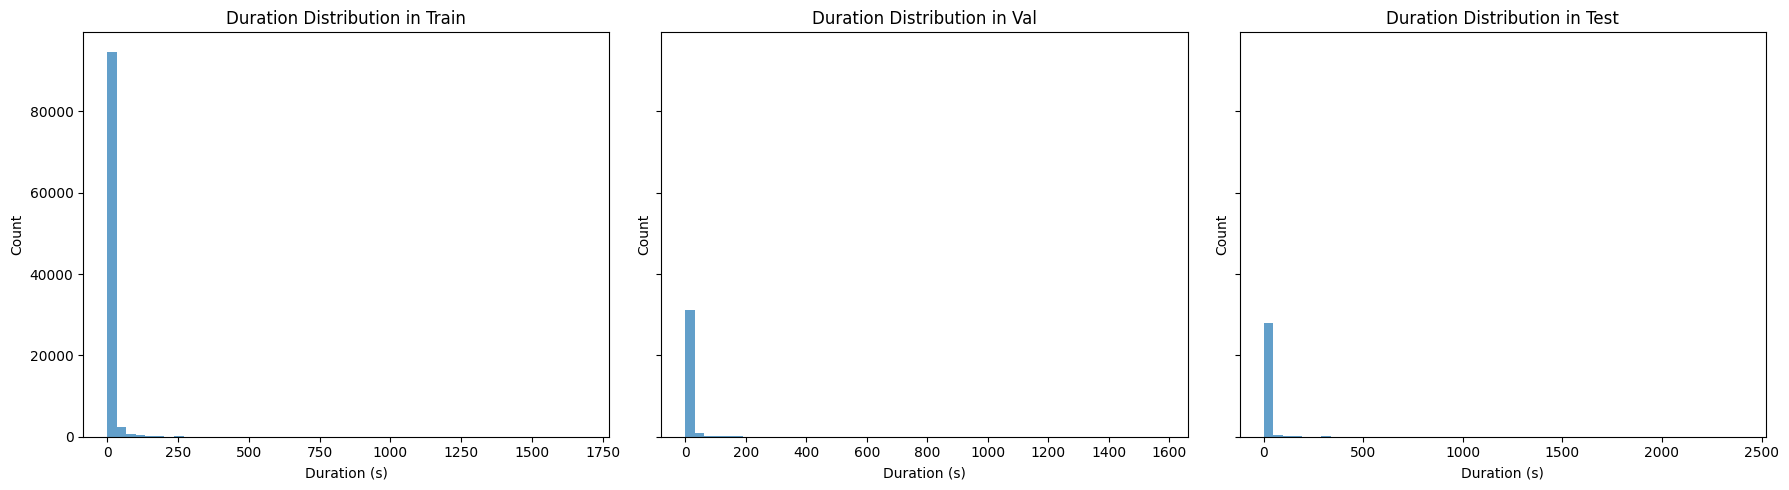

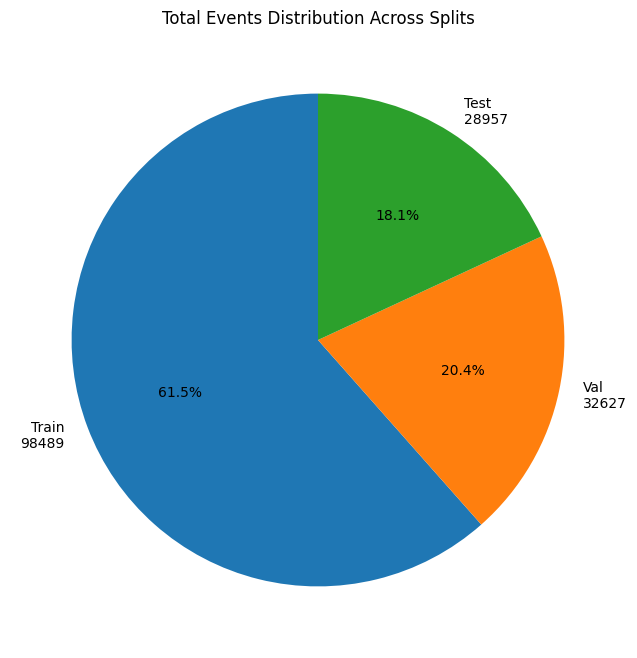

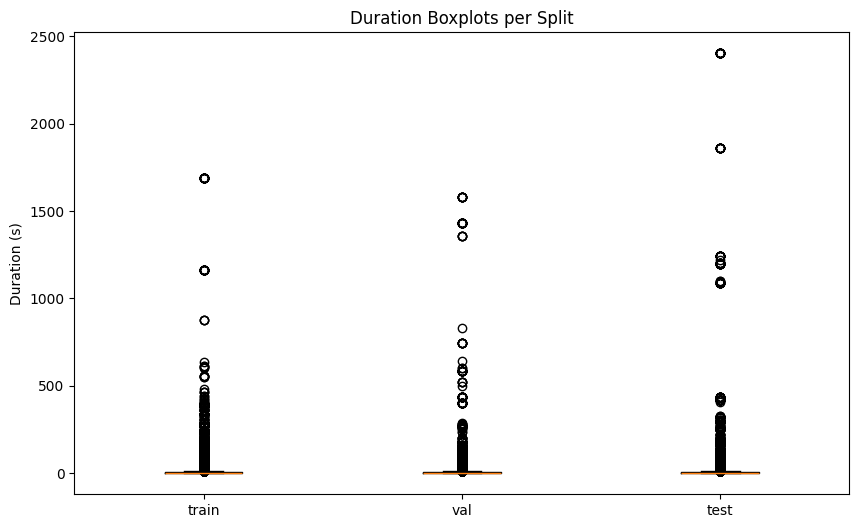

In [13]:
# Visualizations for multi-label stratified split data spread

# Compute per-split statistics
split_stats = {'train': {}, 'val': {}, 'test': {}}

for split_name, subj_list in [('train', train_idx), ('val', val_idx), ('test', test_idx)]:
    split_records = [r for r in records if r['subject'] in subj_list]
    label_counts_split = Counter()
    channel_counts_split = Counter()
    durations_split = []
    files_count = len(split_records)
    subjects_count = len(set(r['subject'] for r in split_records))
    
    for r in split_records:
        meta, events = read_annotation_csv(r['csv'])
        for e in events:
            label_counts_split[e['label']] += 1
            channel_counts_split[e['channel']] += 1
            durations_split.append(e['stop'] - e['start'])
    
    split_stats[split_name] = {
        'label_counts': label_counts_split,
        'channel_counts': channel_counts_split,
        'durations': durations_split,
        'files': files_count,
        'subjects': subjects_count
    }

# 1) Split sizes: subjects and files
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
splits = ['train', 'val', 'test']
subjects = [split_stats[s]['subjects'] for s in splits]
files = [split_stats[s]['files'] for s in splits]

ax1.bar(splits, subjects, color=['blue', 'orange', 'green'])
ax1.set_title('Number of Subjects per Split')
ax1.set_ylabel('Count')

ax2.bar(splits, files, color=['blue', 'orange', 'green'])
ax2.set_title('Number of Files per Split')
ax2.set_ylabel('Count')

plt.tight_layout()
plt.savefig(figs_dir / 'split_sizes_multilabel.png')
plt.show()

# 2) Label distribution per split (top 10)
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
for i, split in enumerate(splits):
    lc = split_stats[split]['label_counts']
    if lc:
        labels, counts = zip(*lc.most_common(10))
        axes[i].bar(labels, counts)
        axes[i].set_title(f'Top 10 Labels in {split.capitalize()}')
        axes[i].tick_params(axis='x', rotation=45)
    else:
        axes[i].text(0.5, 0.5, 'No data', ha='center', va='center', transform=axes[i].transAxes)
        axes[i].set_title(f'{split.capitalize()} Labels')

plt.tight_layout()
plt.savefig(figs_dir / 'label_dist_per_split_multilabel.png')
plt.show()

# 3) Channel distribution per split (top 10)
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
for i, split in enumerate(splits):
    cc = split_stats[split]['channel_counts']
    if cc:
        channels, counts = zip(*cc.most_common(10))
        axes[i].bar(channels, counts)
        axes[i].set_title(f'Top 10 Channels in {split.capitalize()}')
        axes[i].tick_params(axis='x', rotation=45)
    else:
        axes[i].text(0.5, 0.5, 'No data', ha='center', va='center', transform=axes[i].transAxes)
        axes[i].set_title(f'{split.capitalize()} Channels')

plt.tight_layout()
plt.savefig(figs_dir / 'channel_dist_per_split_multilabel.png')
plt.show()

# 4) Duration distributions per split
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
for i, split in enumerate(splits):
    durs = split_stats[split]['durations']
    if durs:
        axes[i].hist(durs, bins=50, alpha=0.7)
        axes[i].set_title(f'Duration Distribution in {split.capitalize()}')
        axes[i].set_xlabel('Duration (s)')
        axes[i].set_ylabel('Count')
    else:
        axes[i].text(0.5, 0.5, 'No data', ha='center', va='center', transform=axes[i].transAxes)
        axes[i].set_title(f'{split.capitalize()} Durations')

plt.tight_layout()
plt.savefig(figs_dir / 'duration_dist_per_split_multilabel.png')
plt.show()

# 5) Pie chart for total events per split
total_events = [sum(split_stats[s]['label_counts'].values()) for s in splits]
fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(total_events, labels=[f'{s.capitalize()}\n{total_events[i]}' for i, s in enumerate(splits)], autopct='%1.1f%%', startangle=90)
ax.set_title('Total Events Distribution Across Splits')
plt.savefig(figs_dir / 'events_pie_multilabel.png')
plt.show()

# 6) Boxplot for durations per split
dur_lists = [split_stats[s]['durations'] for s in splits if split_stats[s]['durations']]
if dur_lists:
    plt.figure(figsize=(10, 6))
    plt.boxplot(dur_lists, labels=[s for s in splits if split_stats[s]['durations']])
    plt.title('Duration Boxplots per Split')
    plt.ylabel('Duration (s)')
    plt.savefig(figs_dir / 'duration_boxplot_multilabel.png')
    plt.show()